In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

# More advanced data augmentation
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets with augmented transforms
dataset = datasets.ImageFolder('rushub', transform=train_transforms)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataset.dataset.transform = train_transforms
test_dataset.dataset.transform = test_transforms

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class FungiNetX(nn.Module):
    def __init__(self, num_classes=32):
        super(FungiNetX, self).__init__()

        # Load the pretrained ResNet50 model
        self.model = models.resnet50(pretrained=True)

        # Fine-tuning more layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        # Modify the fully connected layer
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Instantiate the model
model = FungiNetX()

if torch.cuda.is_available():
    model = model.cuda()

# Experiment with the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

criterion = nn.CrossEntropyLoss()

# Lists to store training and validation accuracy, loss, and validation loss for each epoch
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []
validation_loss_list = []

# Training loop
num_epochs = 30
best_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_dataset)
    train_accuracy = train_correct / len(train_dataset)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)

    model.eval()
    test_correct = 0
    validation_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()

            outputs = model(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()

    validation_loss /= len(test_dataset)
    test_accuracy = test_correct / len(test_dataset)
    validation_accuracy_list.append(test_accuracy)
    validation_loss_list.append(validation_loss)

    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'FungiNetX_Model_12_1_2024.h5')
        best_accuracy = test_accuracy

    scheduler.step()

    print('Epoch: ' + str(epoch) + ' Train Loss: ' + str(train_loss) + ' Train Accuracy: ' + str(
        train_accuracy) + ' Validation Accuracy: ' + str(test_accuracy) + ' Validation Loss: ' + str(validation_loss))



C:\Users\kremp\IdeaProjects\MeteCNN_Alex\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kremp\IdeaProjects\MeteCNN_Alex\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0 Train Loss: 0.5342495467356992 Train Accuracy: 0.8528415881025097 Validation Accuracy: 0.9268357455849157 Validation Loss: 0.230300064684306
Epoch: 1 Train Loss: 0.1925279341747903 Train Accuracy: 0.94250431549595 Validation Accuracy: 0.9236489178064002 Validation Loss: 0.2692233053827615
Epoch: 2 Train Loss: 0.1203956047208791 Train Accuracy: 0.9625215774797503 Validation Accuracy: 0.9264373921126012 Validation Loss: 0.2705318414821455
Epoch: 3 Train Loss: 0.09005071339274748 Train Accuracy: 0.9723476297968398 Validation Accuracy: 0.9321471252157748 Validation Loss: 0.24529752769827637
Epoch: 4 Train Loss: 0.0721388928291204 Train Accuracy: 0.9774266365688488 Validation Accuracy: 0.9259062541495153 Validation Loss: 0.2766468857701058
Epoch: 5 Train Loss: 0.06675849026636668 Train Accuracy: 0.9793852078077281 Validation Accuracy: 0.9314832027619174 Validation Loss: 0.24655972428292397
Epoch: 6 Train Loss: 0.05340414707598506 Train Accuracy: 0.9833023502854866 Validation Accura

In [2]:
print(f'Best Test Accuracy: {best_accuracy:.4f}')

Best Test Accuracy: 0.9596


In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# iterate over test data
for images, labels in test_loader:
    if torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda()

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    # Convert to numpy arrays
    labels = labels.cpu().numpy()
    predicted = predicted.cpu().numpy()

    true_labels.extend(labels)
    predicted_labels.extend(predicted)

# constant for classes (adjust to your actual class labels)
classes = [str(i) for i in range(32)]

# Build confusion matrix
cf_matrix = confusion_matrix(true_labels, predicted_labels)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=classes, columns=classes)

# Plot confusion matrix
plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig('confusion_matrix.png')


KeyboardInterrupt: 

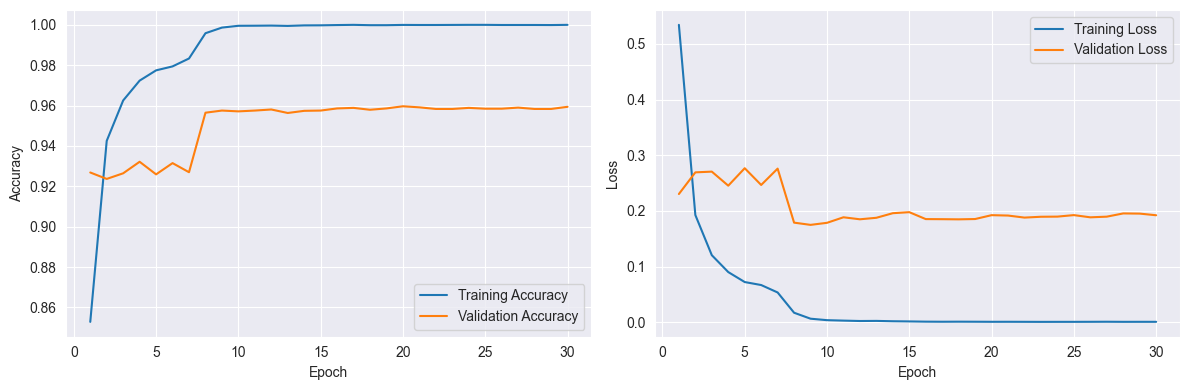

In [7]:
# Plotting the training and validation accuracy, loss, and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracy_list, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), validation_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_loss_list, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

predicted class: Jedovata Amanita muscaria
Predicted Class: 14


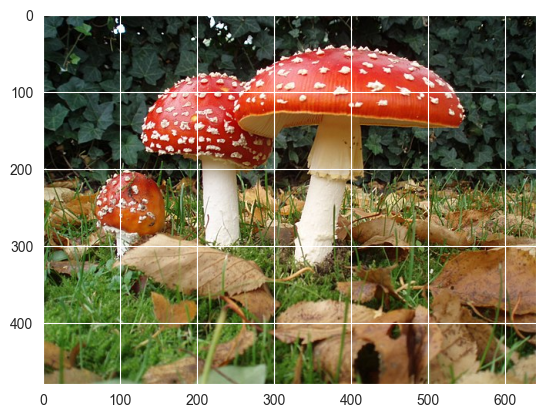

In [10]:
from PIL import Image
from torchvision import transforms


# Load the trained model
model = FungiNetX()
model.load_state_dict(torch.load('Fungi_CNN_Model.h5'))
dataset = datasets.ImageFolder('rushub', transform=train_transforms)

# Print the entire class names list
class_names = dataset.classes
# print("Class Names:", class_names)

# Move the model to the appropriate device (GPU if available)
if torch.cuda.is_available():
    model = model.cuda()

model.eval()

# Preprocess the new image
new_image_path = 'tasting/Amanita_muscaria_3_vliegenzwammen_op_rij.jpg'
new_image = Image.open(new_image_path).convert('RGB')
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(new_image)
input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

# Move the input data to the same device as the model
if torch.cuda.is_available():
    input_batch = input_batch.cuda()

# Make prediction
with torch.no_grad():
    output = model(input_batch)


# Get predicted class
_, predicted_class = torch.max(output.data, 1)
predicted_class_name = class_names[predicted_class.item()]
plt.imshow(new_image)
print("predicted class:", predicted_class_name)
print(f'Predicted Class: {predicted_class.item()}')


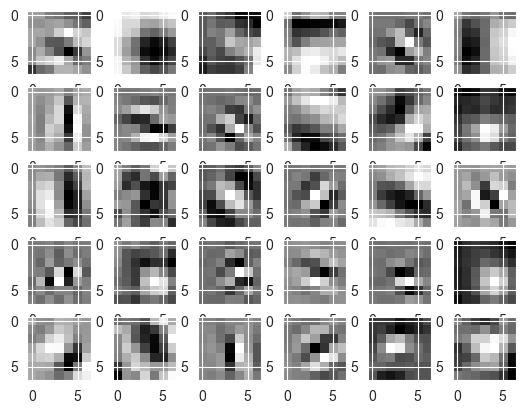

In [11]:
from matplotlib import pyplot as plt

# Access the first layer weights of the ResNet model
weights = model.model.conv1.weight.data.cpu()

# Plot the first layer features
for i in range(0, 30):
    plt.subplot(5, 6, i + 1)
    plt.imshow(weights[i, 0, :, :], cmap=plt.get_cmap('gray'))
plt.show()
